# Librerías

In [28]:
import pandas as pd
from palette_creator import PaletteCreator, show_palette
from pathlib import Path
import cv2
import json

# Funciones auxiliares

In [29]:
class DataLoader:
    def __init__(self, file_list, batch_size, pre_process=None):
        self.batch_size = batch_size
        self.file_list = file_list
        self.num_samples = len(self.file_list)
        self.num_batches = (self.num_samples + batch_size - 1) // batch_size
        self.current_batch = 0
        self.pre_process = pre_process

    def __iter__(self):
        return self
    
    def load_img(self, path_img):
        path_img = str(path_img)

        # Check if path exists
        if not Path(path_img).exists():
            print(f"Path {path_img} doesn't exist")
            return None
        
        if self.pre_process is not None:
            return self.pre_process(cv2.cvtColor(cv2.imread(path_img), cv2.COLOR_BGR2RGB))
        
        return cv2.cvtColor(cv2.imread(path_img), cv2.COLOR_BGR2RGB)
    
    def __len__(self):
        return self.num_batches

    def __next__(self):
        if self.current_batch < self.num_batches:
            batch_start = self.current_batch * self.batch_size
            batch_end = (self.current_batch + 1) * self.batch_size
            batch_files = self.file_list[batch_start:batch_end]

            batch_images = [self.load_img(file) for file in batch_files]
            self.batch_size = len(batch_images)
            self.current_batch += 1
            return batch_images
        else:
            self.current_batch = 0
            raise StopIteration
        
    def __item__(self, index):
        if isinstance(index, slice):
            return [self.load_img(file) for file in self.file_list[index]]
        return self.load_img(self.file_list[index])
    
    def __getitem__(self, index):
        return self.__item__(index)

In [30]:
import numpy as np

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32,
                              np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

def save_results_to_db(db, method, results): 
    palettes, proportions = results
    db[f"{method}_palette"], db[f"{method}_proportions"] = palettes, proportions
    db[f"{method}_palette"] = db[f"{method}_palette"].apply(lambda x: json.dumps(x, cls=NumpyEncoder))
    db[f"{method}_proportions"] = db[f"{method}_proportions"].apply(lambda x: json.dumps(x, cls=NumpyEncoder))

# Configuración

In [31]:
# establecer rutas
PATH_IMAGES_FOLDER = Path('data/beatriz_gonzalez')
PATH_IMAGES_METADATA = Path("beatriz_gonzalez.csv")

db = pd.read_csv(PATH_IMAGES_METADATA)
db["path_image"] = PATH_IMAGES_FOLDER/db["filename"]

# Preprocesamiento
Cargar imagenes y aplicarles filtros de ser necesario

Filtros de preprocesamiento a aplicar

In [32]:
# Rezise image if it is too big
def resize(img):
    while img.size > 40000:
        img = cv2.resize(img, None, fx = 0.75, fy = 0.75)
    return img

pre_process = resize

In [33]:
images = DataLoader(db["path_image"], 10, pre_process) # cargar imagenes en una lista

(-0.5, 125.5, 92.5, -0.5)

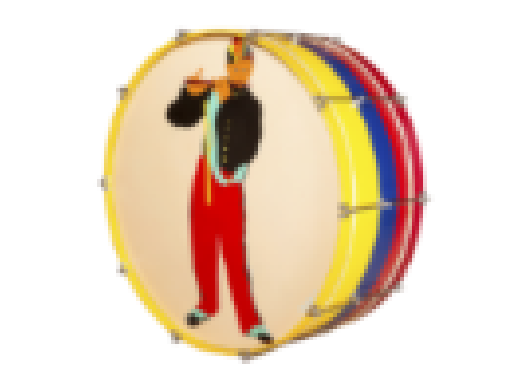

In [34]:
import matplotlib.pyplot as plt
plt.imshow(images[18])
plt.axis('off')

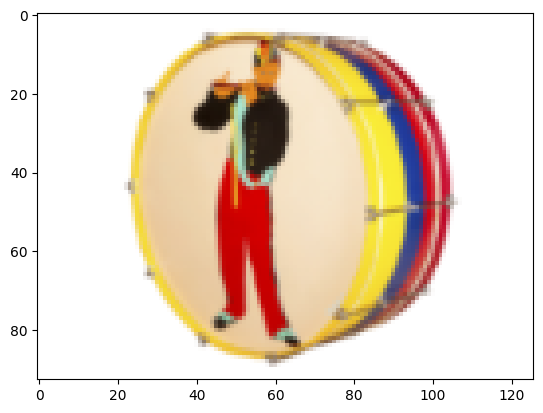

In [35]:
# aplicar filtros que homogenicen las imágenes
test = pre_process(images[18])
plt.imshow(test)
# plt.axis('off')

# Procesamiento PNN

In [36]:
pc = PaletteCreator(method="pnn", palette_method="mean")

In [37]:
import multiprocessing

def process_batch(batch):
    palette, proportions = pc.create_palette(batch)
    return palette, proportions

def process_images(images):
    results = [[], [], []]

    # Create a Pool of worker processes
    with multiprocessing.Pool(processes=10) as pool:
        # Map the function and iterable to the Pool of processes
        raw_results = pool.map(process_batch, images)
    
    for palette, proportions in raw_results:
        results[0].extend(palette)
        results[1].extend(proportions)

    return results

In [38]:
%%time
import os
import time
batch_size = 100
final_results = [[], []]
for i in range(0, len(db["path_image"]), batch_size):
    start = i
    end = min(i + batch_size, len(db["path_image"]))
    print(len(db["path_image"][start:end]))
    images = DataLoader(db["path_image"][start:end], 10, pre_process) # cargar imagenes en una lista
    results = process_images(images)
    final_results[0].extend(results[0])
    final_results[1].extend(results[1])
    print(f"Processed images {start} to {end}")
    # time.sleep(1)

save_results_to_db(db, f'{pc.method}-mean+resize', final_results)
db.to_csv(PATH_IMAGES_METADATA, index=False)

100


100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


Processed images 0 to 100
100


100%|██████████| 10/10 [01:06<00:00,  6.70s/it]


Processed images 100 to 200
100


100%|██████████| 10/10 [01:00<00:00,  6.05s/it]


Processed images 200 to 300
100


100%|██████████| 10/10 [01:05<00:00,  6.52s/it]


Processed images 300 to 400
100


100%|██████████| 10/10 [01:04<00:00,  6.42s/it]


Processed images 400 to 500
100


100%|██████████| 10/10 [01:08<00:00,  6.80s/it]


Processed images 500 to 600
100


100%|██████████| 10/10 [01:06<00:00,  6.67s/it]


Processed images 600 to 700
100


100%|██████████| 10/10 [01:06<00:00,  6.67s/it]


Processed images 700 to 800
100


100%|██████████| 10/10 [01:04<00:00,  6.47s/it]


Processed images 800 to 900
100


100%|██████████| 10/10 [01:09<00:00,  6.94s/it]


Processed images 900 to 1000
100


100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


Processed images 1000 to 1100
100


100%|██████████| 10/10 [01:04<00:00,  6.46s/it]


Processed images 1100 to 1200
38


100%|██████████| 10/10 [00:49<00:00,  4.99s/it]


Processed images 1200 to 1238
CPU times: user 1min 8s, sys: 25.4 s, total: 1min 34s
Wall time: 14min 22s


In [39]:
len(final_results[0]), len(final_results[1])

(1238, 1238)

# Ejemplo de mapeo de la imagen (Segmentos con su respectivo color representante)

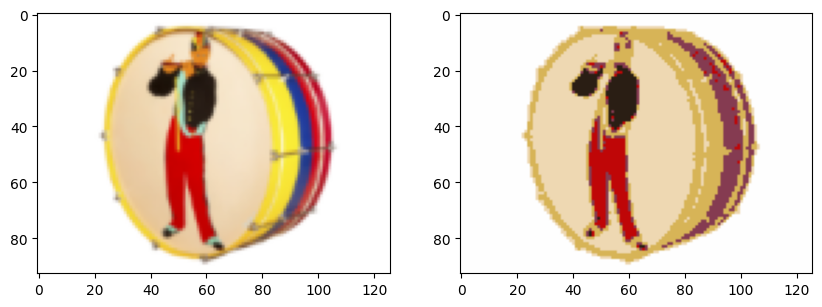

In [24]:
# Ejemplo de segmentación realizada por el método
pc.model.show_mapped_img(pc, test, palette_method="mean")

# Ejemplo de visualización

In [25]:
db = pd.read_csv(PATH_IMAGES_METADATA)

In [26]:
palette_img = db[f'{pc.method}-mean+resize_palette'].values
proportions_img = db[f'{pc.method}-mean+resize_proportions'].values

(1200, 863, 3)


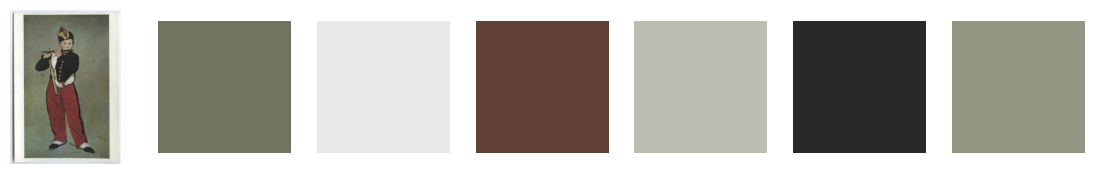

(800, 1200, 3)


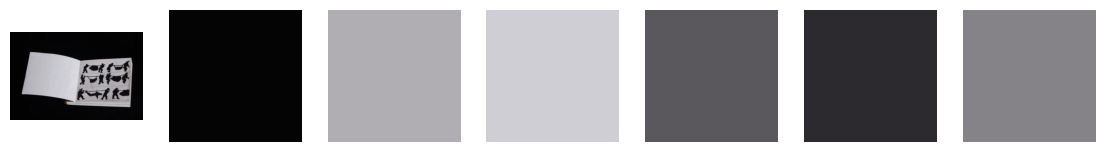

(1200, 800, 3)


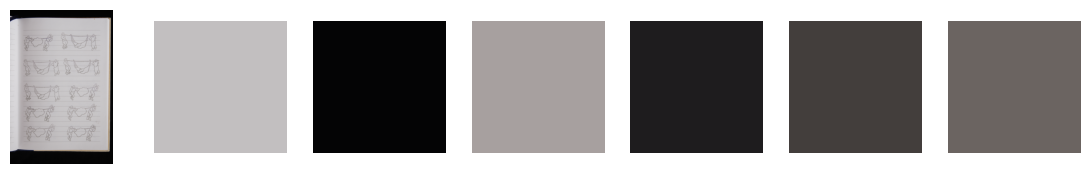

(1134, 778, 3)


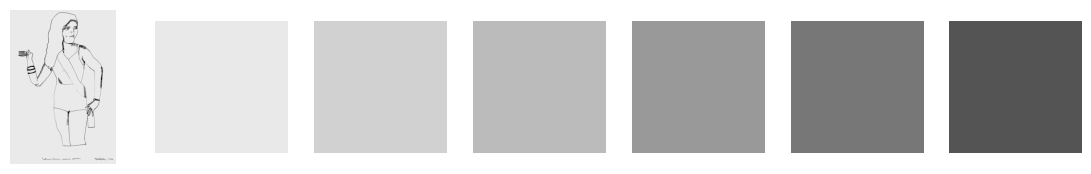

(1800, 1200, 3)


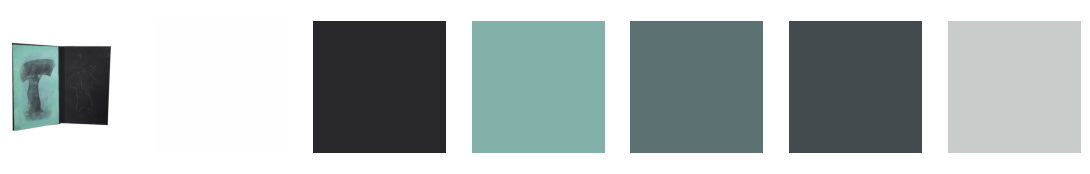

(1073, 1200, 3)


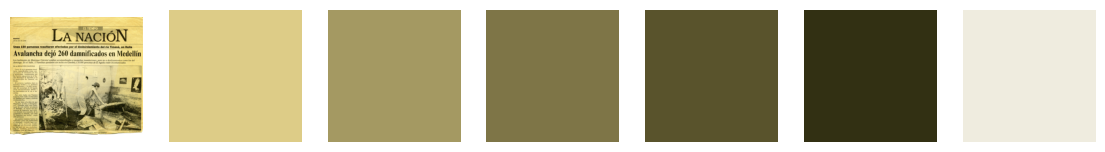

(531, 1200, 3)


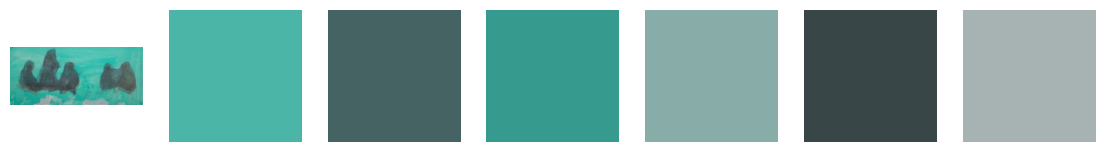

(476, 1200, 3)


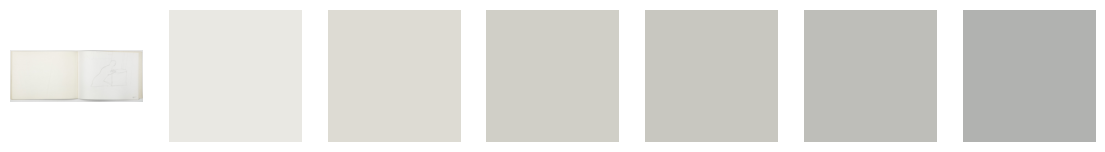

(1200, 1015, 3)


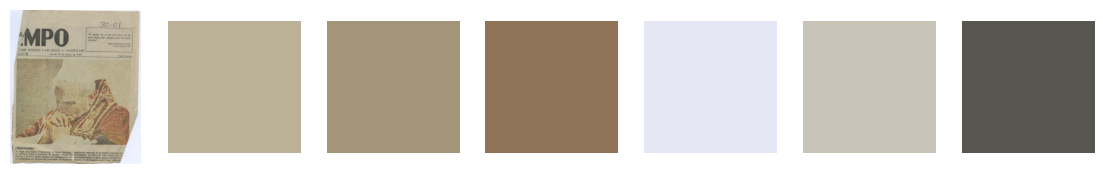

(1200, 850, 3)


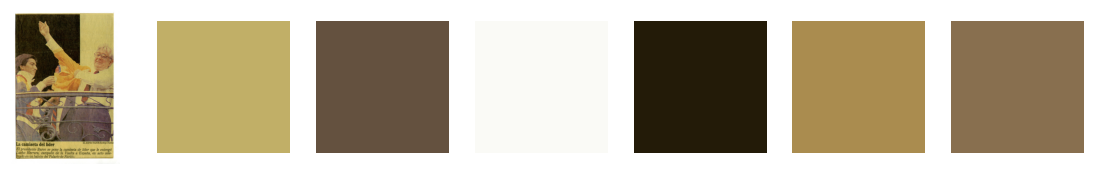

(984, 1200, 3)


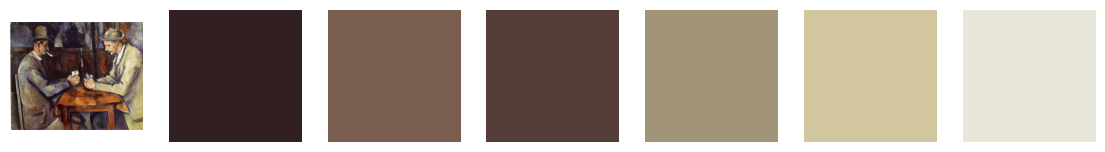

(869, 1200, 3)


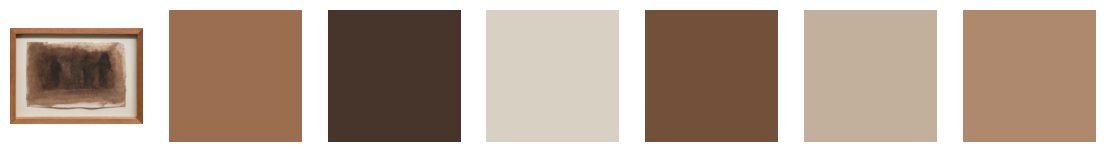

(1200, 767, 3)


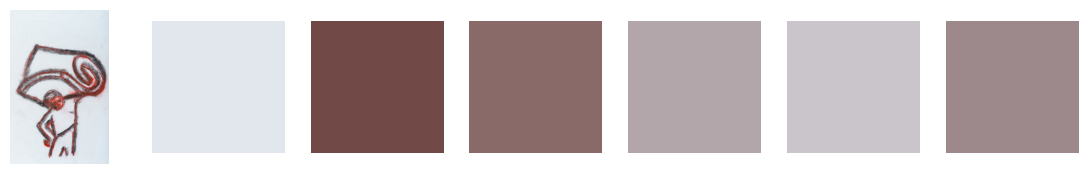

(1200, 874, 3)


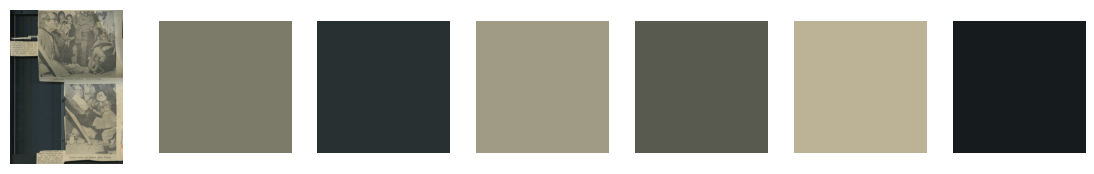

(1200, 789, 3)


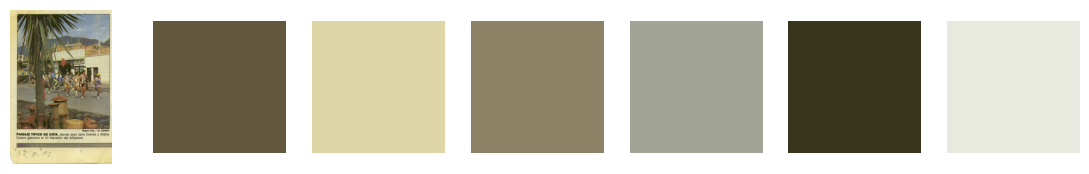

(841, 1200, 3)


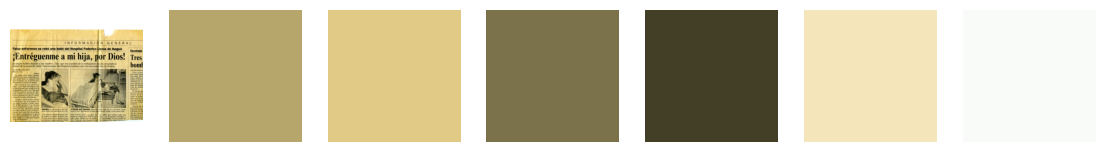

(6586, 4548, 3)


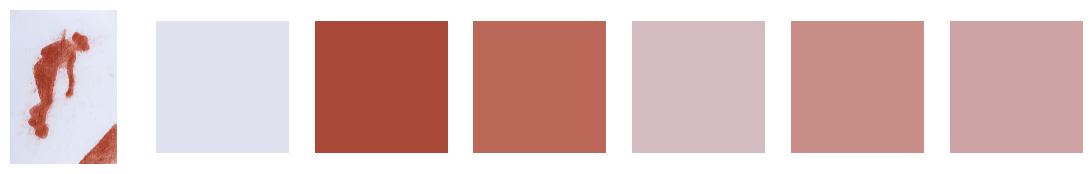

(785, 661, 3)


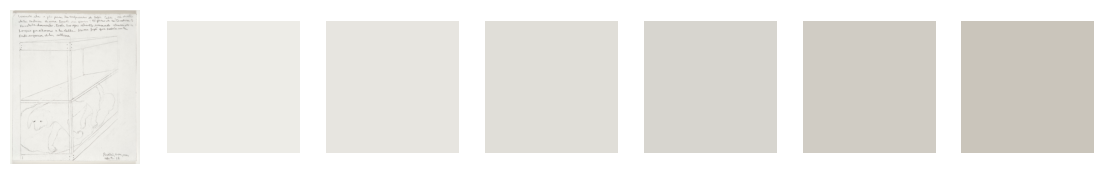

(1654, 2244, 3)


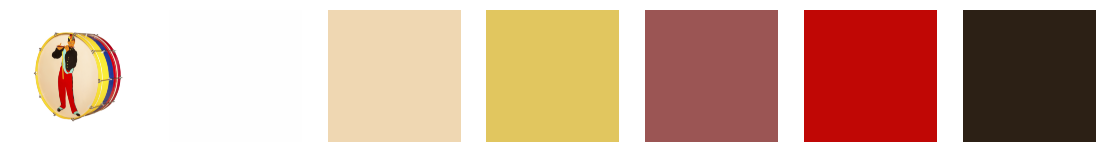

(843, 1200, 3)


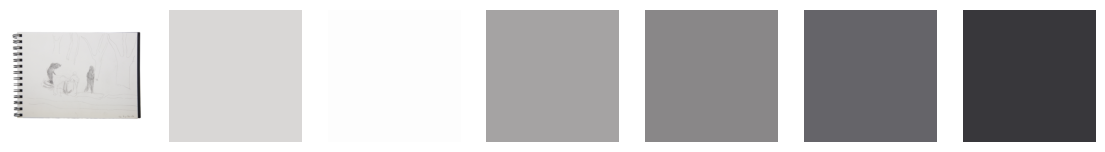

(1200, 745, 3)


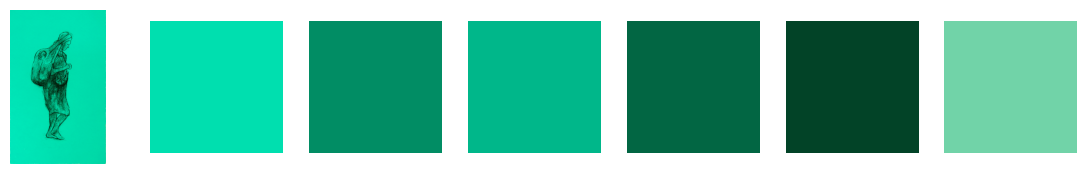

(856, 1200, 3)


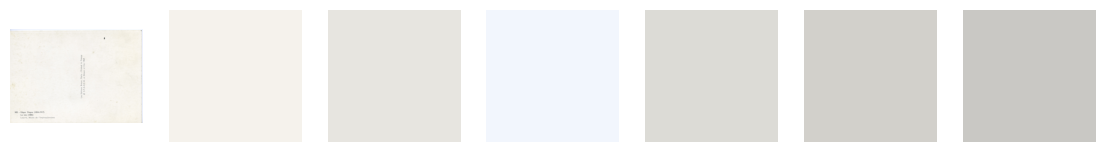

(848, 1200, 3)


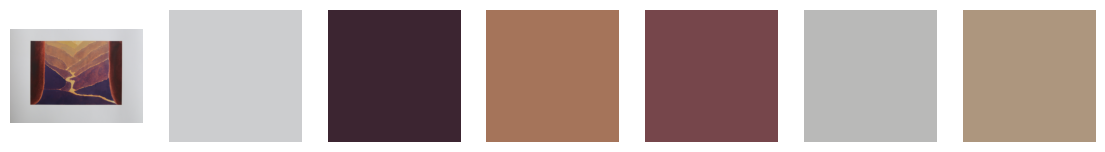

(1080, 1200, 3)


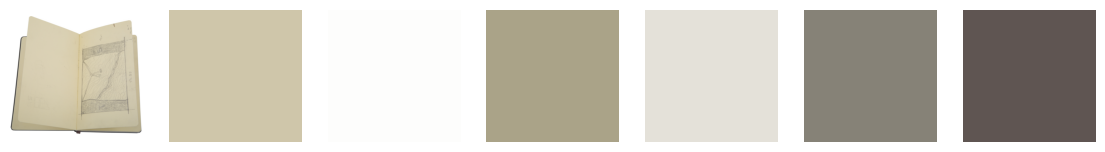

(4000, 3691, 3)


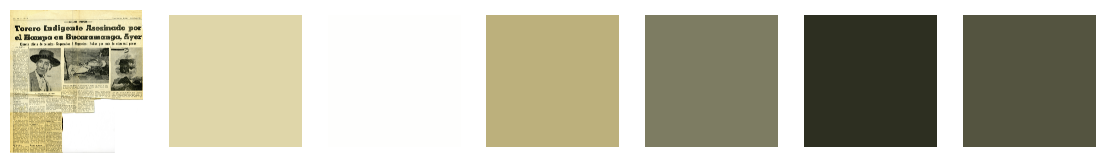

(993, 1200, 3)


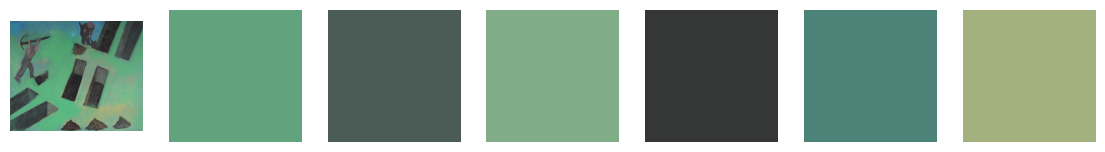

(218, 76, 3)


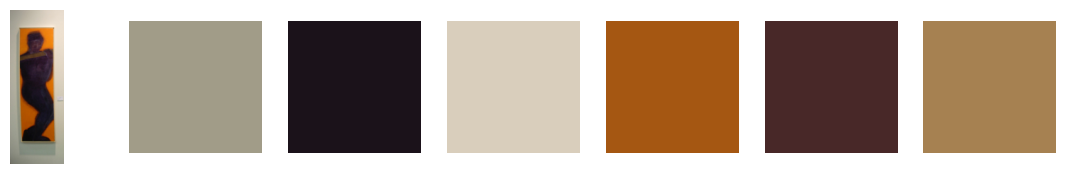

(835, 2908, 3)


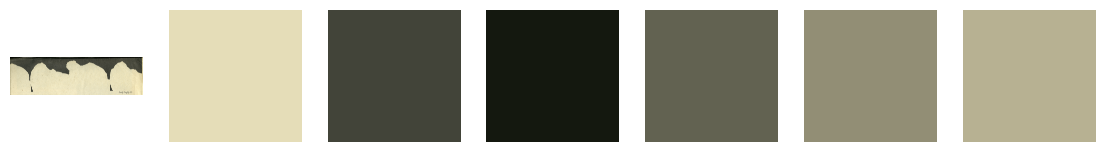

(3613, 1596, 3)


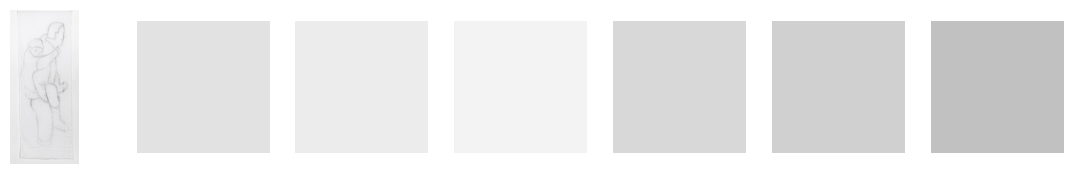

(3548, 3891, 3)


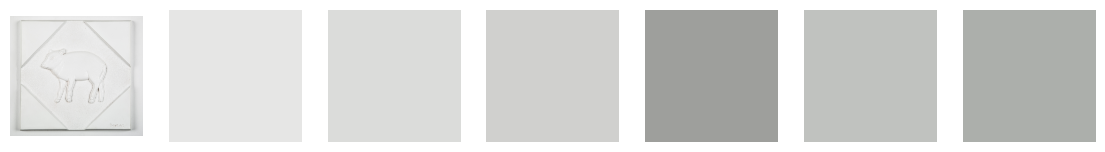

(5662, 2147, 3)


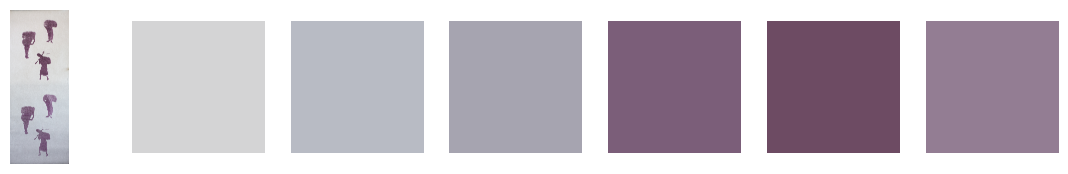

(3471, 3484, 3)


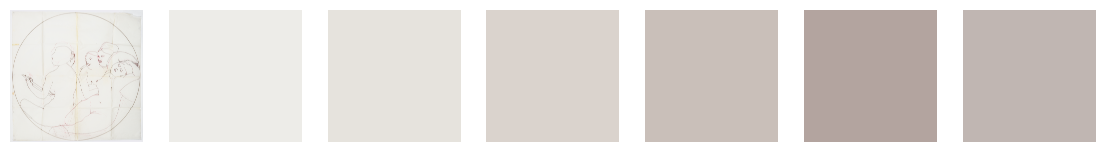

(1200, 1084, 3)


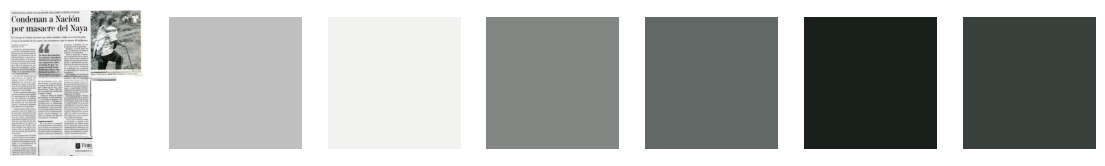

(799, 1200, 3)


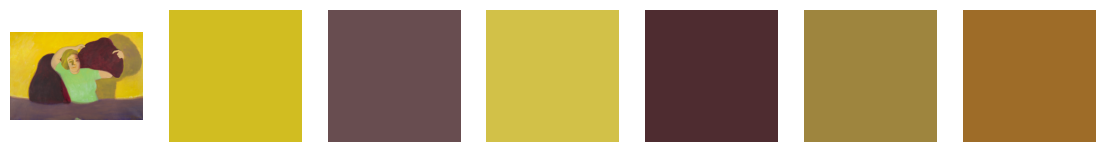

(1572, 4000, 3)


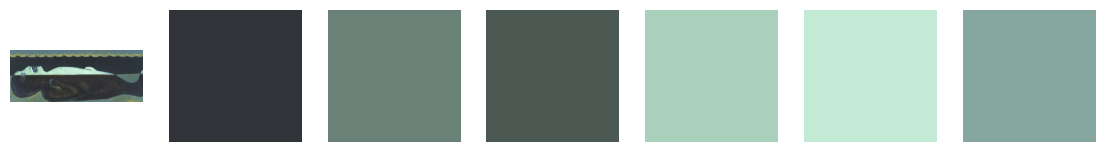

(4000, 2384, 3)


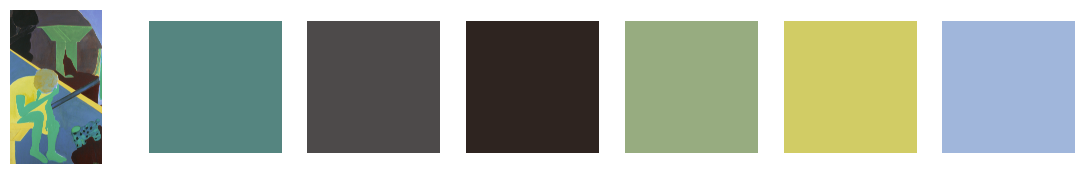

(1155, 765, 3)


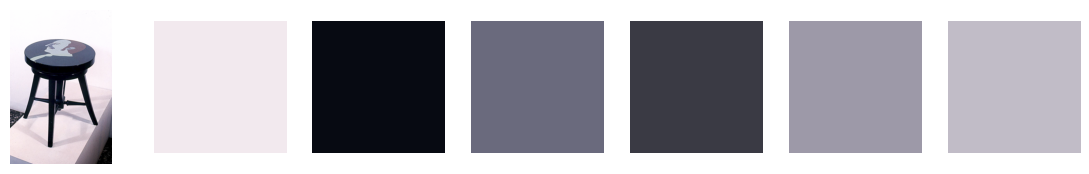

(593, 398, 3)


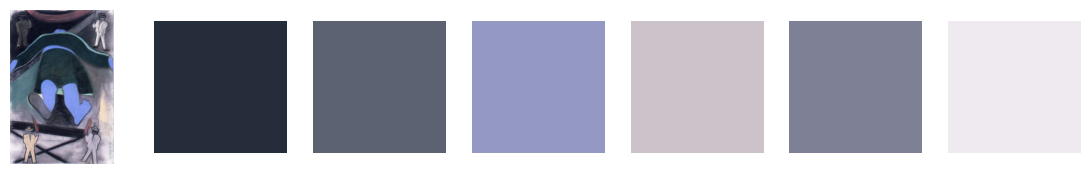

(925, 1200, 3)


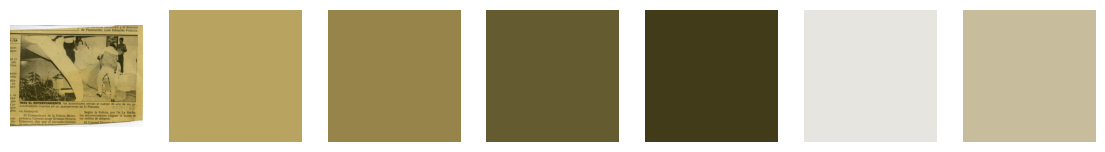

(992, 1200, 3)


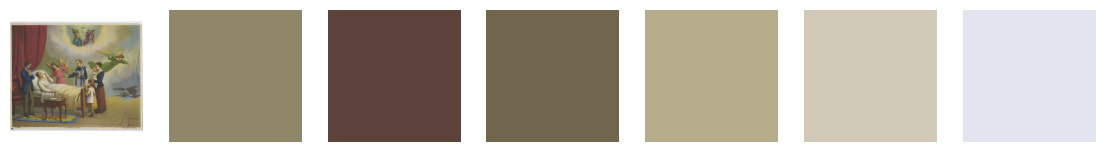

(932, 2870, 3)


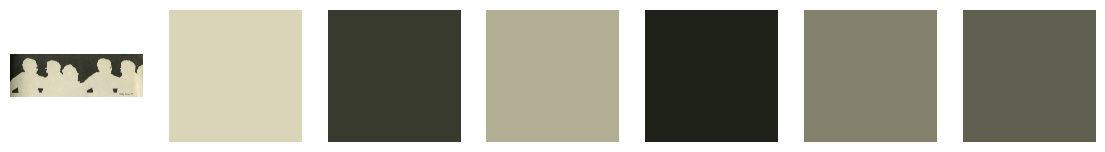

(1142, 829, 3)


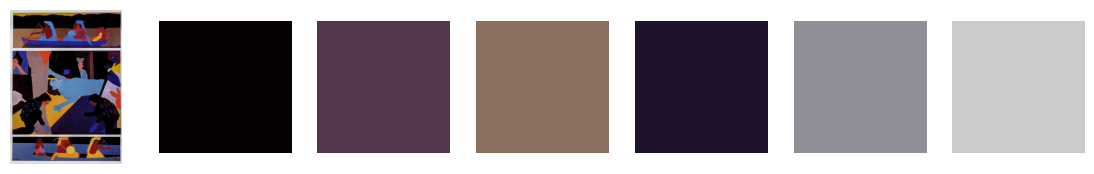

(772, 1200, 3)


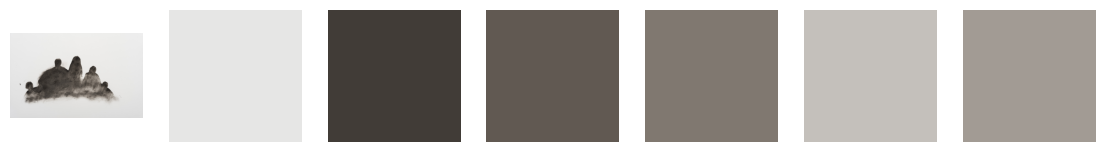

(1200, 1200, 3)


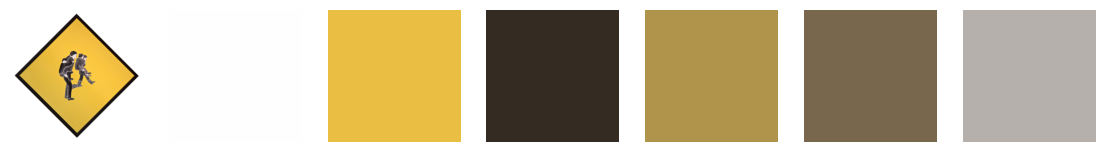

(1200, 812, 3)


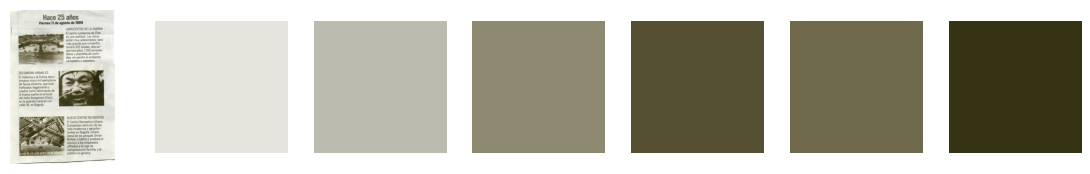

(705, 516, 3)


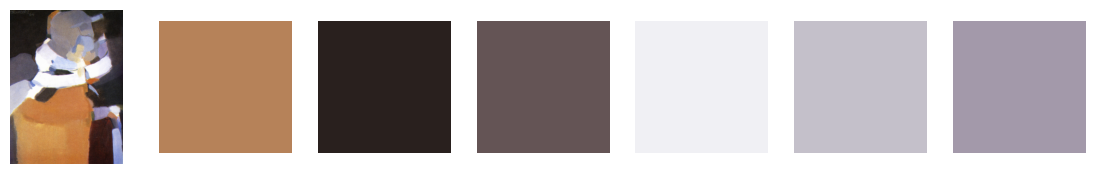

(992, 1134, 3)


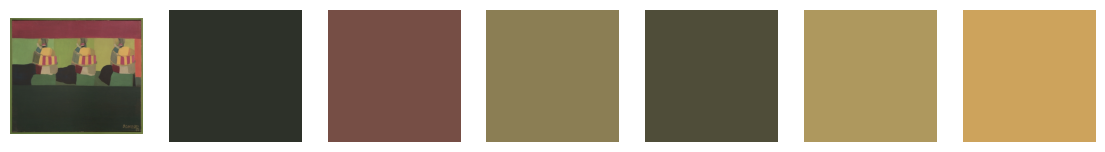

(1200, 1200, 3)


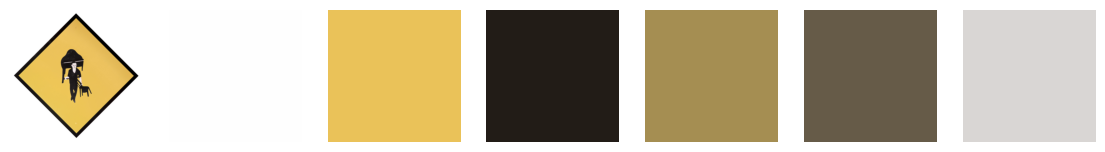

(2813, 3814, 3)


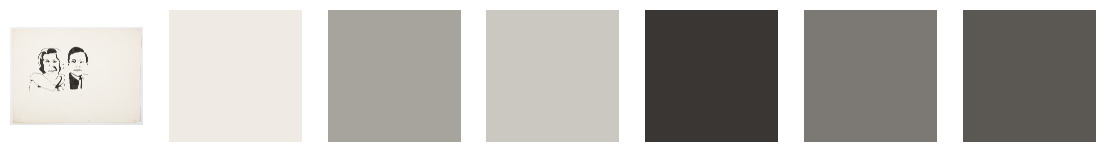

(3756, 2599, 3)


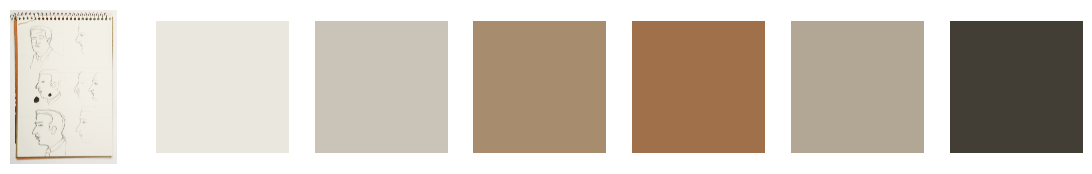

In [27]:
import ast
images = DataLoader(db["path_image"], 10)

for i, image in enumerate(images[:50]):
    print(image.shape)
    if image is not None:
        img_palette = ast.literal_eval(palette_img[i])
        show_palette(img_palette, img=image)